In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
import datetime
import importlib
import sys
sys.path.append('/home/apaulson/repos/data-proc')
import mysql_cnx

In [6]:
importlib.reload(mysql_cnx)
cnx=mysql_cnx.create_mysql_cnx()

# Affiliates

In [7]:
affiliate_category_1="""
SELECT DISTINCT 
    HP_ID,
    DM_ID,
    IFNULL(YEAR(DATE_FORMAT(SUBSTRING(HAV_VERSION, 1, 8), '%%Y%%m%%d')), YEAR(HAV_INS_DATE)) AS SCT_YEAR, 
    IFNULL(DAC_NAME, "Unknown") AS Property 
FROM HTS_PROJECT
INNER JOIN HTS_ASSAY hts ON HA_HP_ID = HP_ID AND HA_FILTER = 0 AND hts.class = "hits.hts.HighThroughputAssay"            
LEFT JOIN HTS_ASSAY htl ON htl.HA_DR_RAW = hts.HA_ID
INNER JOIN HTS_ASSAY_VERSION ON HAV_HA_ID = hts.HA_ID
LEFT JOIN DIRECTORY_MEMBER ON DM_ID = HP_LABOWNER_UID
LEFT JOIN DIRECTORY_AFFILIATE_CATEGORY ON DAC_ID = DM_DAC_ID
WHERE HP_SCREENING_CENTER in ('SMDC','Strateos') AND HP_SDESC != "Demo" AND ISNULL(htl.HA_ID)
"""
affiliate_category_2="""
SELECT DISTINCT 
    HP_ID, 
    IFNULL(YEAR(DATE(HLRS_DATE_RUN)), YEAR(HLRS_INS_DATE)) AS SCT_YEAR,
    IFNULL(DAC_NAME, "Unknown") AS Property 
FROM HTS_PROJECT
INNER JOIN HTL_ASSAY ON HLA_HP_ID = HP_ID
INNER JOIN HTL_RESULT_SERIES ON HLRS_HLA_ID = HLA_ID
LEFT JOIN DIRECTORY_MEMBER ON DM_ID = HP_LABOWNER_UID
LEFT JOIN DIRECTORY_AFFILIATE_CATEGORY ON DAC_ID = DM_DAC_ID
WHERE HP_SCREENING_CENTER in ('SMDC','Strateos') AND HP_SDESC != "Demo"
"""
uc_category_1="""
SELECT DISTINCT 
    HP_ID, 
    IFNULL(YEAR(DATE_FORMAT(SUBSTRING(HAV_VERSION, 1, 8), "%%Y%%m%%d")), YEAR(HAV_INS_DATE)) AS SCT_YEAR,  
    IFNULL(DA_NAME, "Unknown") AS Property 
FROM HTS_PROJECT
INNER JOIN HTS_ASSAY hts ON HA_HP_ID = HP_ID AND HA_FILTER = 0 AND hts.class = "hits.hts.HighThroughputAssay"
LEFT JOIN HTS_ASSAY htl ON htl.HA_DR_RAW = hts.HA_ID            
INNER JOIN HTS_ASSAY_VERSION ON HAV_HA_ID = hts.HA_ID
LEFT JOIN DIRECTORY_MEMBER ON DM_ID = HP_LABOWNER_UID
LEFT JOIN DIRECTORY_AFFILIATE ON DA_ID = DM_DA_ID
LEFT JOIN DIRECTORY_AFFILIATE_CATEGORY ON DAC_ID = DM_DAC_ID
WHERE HP_SCREENING_CENTER in ('SMDC','Strateos') AND DAC_NAME = "Academic-UC" AND HP_SDESC != "Demo" AND ISNULL(htl.HA_ID)
"""
uc_category_2="""
SELECT DISTINCT 
    HP_ID, 
    IFNULL(YEAR(DATE(HLRS_DATE_RUN)), YEAR(HLRS_INS_DATE)) AS SCT_YEAR,
    IFNULL(DA_NAME, "Unknown") AS Property 
FROM HTS_PROJECT
INNER JOIN HTL_ASSAY ON HLA_HP_ID = HP_ID
INNER JOIN HTL_RESULT_SERIES ON HLRS_HLA_ID = HLA_ID
LEFT JOIN DIRECTORY_MEMBER ON DM_ID = HP_LABOWNER_UID
LEFT JOIN DIRECTORY_AFFILIATE ON DA_ID = DM_DA_ID
LEFT JOIN DIRECTORY_AFFILIATE_CATEGORY ON DAC_ID = DM_DAC_ID
WHERE HP_SCREENING_CENTER in ("SMDC",'Strateos') AND DAC_NAME = "Academic-UC" AND HP_SDESC != "Demo"
"""

In [8]:
aff2=pd.read_sql(affiliate_category_2, cnx)

aff1=pd.read_sql(affiliate_category_1, cnx)
aff=aff1.merge(aff2, how='outer')
aff.shape
aff=pd.pivot_table(data=aff, index='SCT_YEAR', columns='Property', aggfunc=pd.Series.nunique, fill_value=0).reset_index()
aff.columns = aff.columns.get_level_values(1)
aff=aff.rename(columns={'':'Year'})
aff.columns

aff=aff.melt(id_vars='Year', value_vars=['Academic-UC', 'Academic/Government', 'Corporate'])
aff.columns=['Year','Affiliate Category','Projects']

In [9]:
aff1[aff1.Property.isin(['Personal','Unknown'])]

,HP_ID,DM_ID,SCT_YEAR,Property
255,317,630,2023,Unknown


In [10]:
aff2[aff2.Property.isin(['Personal','Unknown'])]

,HP_ID,SCT_YEAR,Property


In [11]:
uc2=pd.read_sql(uc_category_2, cnx)

uc1=pd.read_sql(uc_category_1, cnx)
uc=uc1.merge(uc2, how='outer')
uc.shape
uc=pd.pivot_table(data=uc, index='SCT_YEAR', columns='Property', aggfunc=pd.Series.nunique, fill_value=0).reset_index()
uc.columns = uc.columns.get_level_values(1)
uc=uc.rename(columns={'':'Year'})
uc.columns

Index(['Year', 'UC Berkeley', 'UC Davis', 'UC San Diego', 'UC San Francisco',
       'UC Santa Cruz', 'Unknown'],
      dtype='object', name='Property')

In [12]:
uc=uc.melt(id_vars='Year', value_vars=['UC Berkeley', 'UC Davis', 'UC San Diego', 'UC San Francisco',
       'UC Santa Cruz', 'Unknown'])
uc.columns=['Year','Affiliate Category','Projects']

In [13]:
uc['Affiliate Category']=['Other UC' if x!='UC San Francisco' else x for x in uc['Affiliate Category']]
uc.Projects.sum()

268

In [14]:
print(aff.shape)
aff=aff[aff['Affiliate Category']!='Academic-UC']
print(aff.shape)
aff=pd.concat([aff,uc])
aff.shape

(114, 3)
(76, 3)


(190, 3)

In [15]:
aff=aff[aff.Year<2023]

In [16]:
aff=aff.replace('Unknown','Personal')

In [17]:
from pandas.api.types import CategoricalDtype
affcat = CategoricalDtype(categories=['UC San Francisco',
                                      'Other UC',
                                      'Academic/Government',
                                      'Corporate'], ordered=True)


In [18]:
aff['Affiliate Category']=aff['Affiliate Category'].astype(affcat)

In [19]:
aff=aff.groupby(['Year','Affiliate Category']).sum().reset_index()
aff

,Year,Affiliate Category,Projects
0,2005,UC San Francisco,2
1,2005,Other UC,0
2,2005,Academic/Government,0
3,2005,Corporate,2
4,2006,UC San Francisco,5
...,...,...,...
67,2021,Corporate,0
68,2022,UC San Francisco,21
69,2022,Other UC,0
70,2022,Academic/Government,0


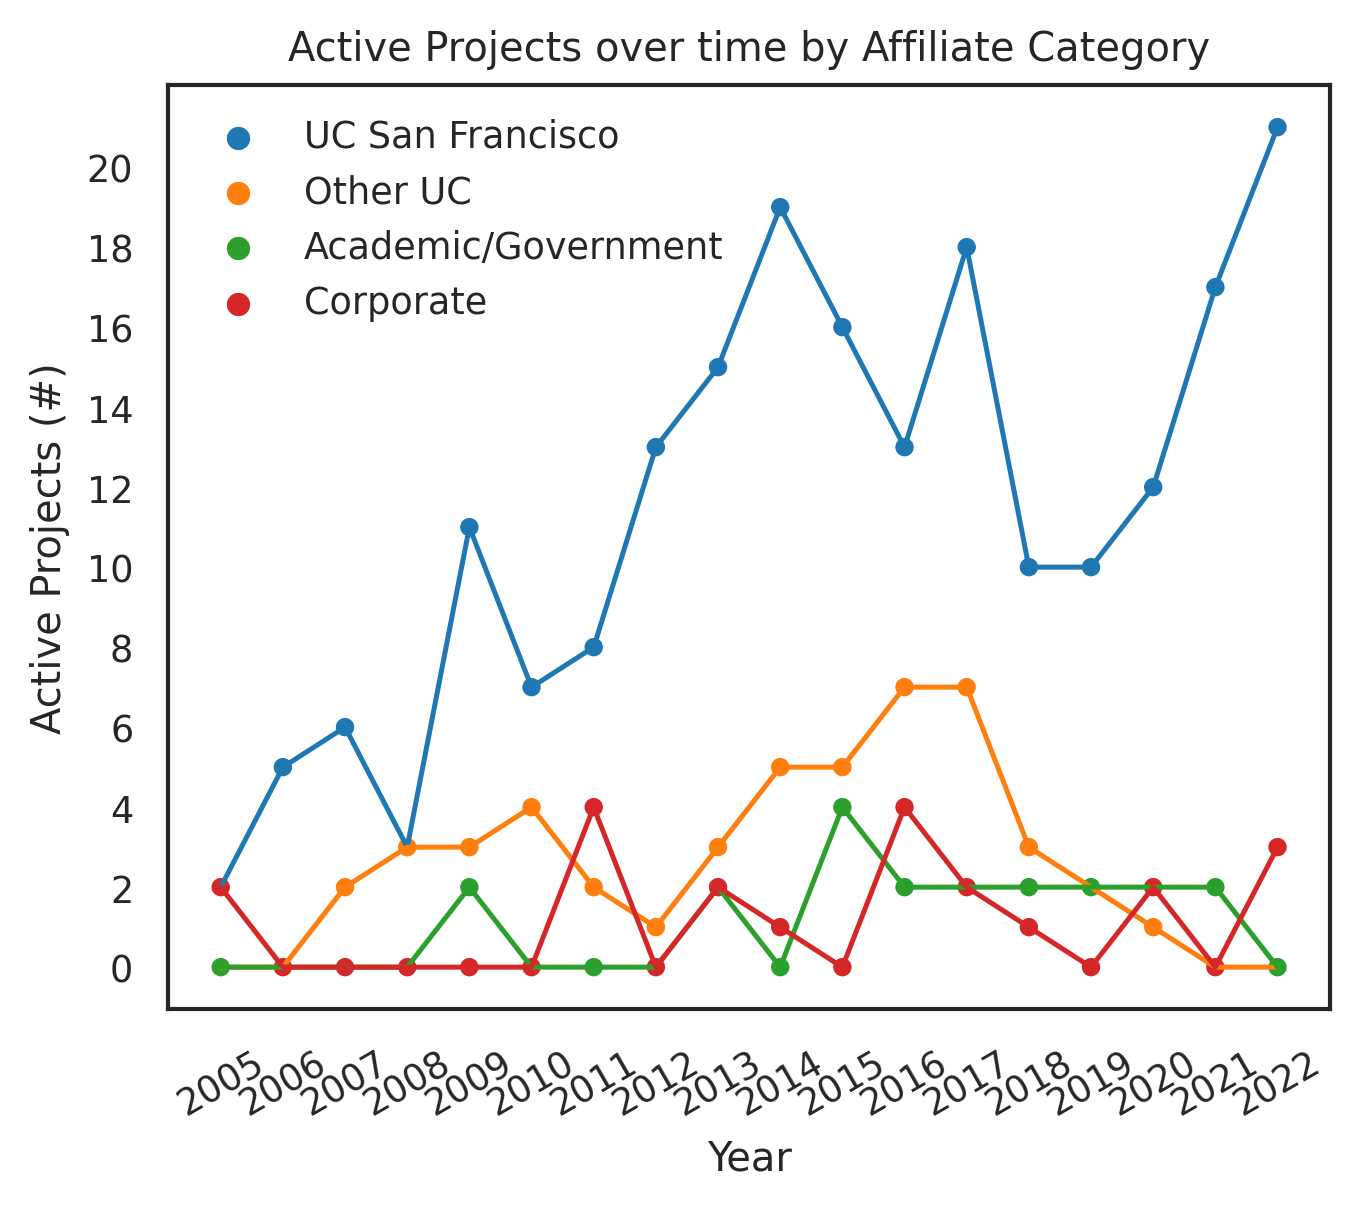

In [20]:
sns.set_style('white')
sns.set_context('paper')
fig, ax = plt.subplots(1,figsize=(5,4) ,dpi=300)
sns.scatterplot(aff, x='Year',y='Projects',hue='Affiliate Category')
sns.lineplot(aff, x='Year',y='Projects',hue='Affiliate Category', legend=False)
ax.set_xticks(aff.Year.unique(), aff.Year.unique(), rotation=30, horizontalalignment='center')
ax.set_yticks([0,2,4,6,8,10,12,14,16,18,20], [0,2,4,6,8,10,12,14,16,18,20])
ax.legend(frameon=False)
ax.set_ylabel('Active Projects (#)')
ax.set_title('Active Projects over time by Affiliate Category');

# Projects, Assays

In [21]:
query=f"""
SELECT DISTINCT 
    HP_ID, 
    HLA_ID, 
    HLRS_ICL_ID, 
    IFNULL(YEAR(DATE(HLRS_DATE_RUN)), YEAR(HLRS_INS_DATE)) AS Y 
FROM HTS_PROJECT
INNER JOIN HTL_ASSAY ON HLA_HP_ID = HP_ID
INNER JOIN HTL_RESULT_SERIES ON HLRS_HLA_ID = HLA_ID
WHERE HP_SCREENING_CENTER in ('SMDC','Strateos') AND HP_SDESC != "Demo";
"""
# with cnx.connect() as conn:
pa2=pd.read_sql(query, cnx)

In [24]:
# pa1=pd.read_csv('charts_projects_assays_20230223_1.csv')
# pa3=pd.read_csv('charts_projects_assays_20230223_3.csv')
# pa4=pd.read_csv('charts_projects_assays_20230223_4.csv')
pa2.head()

,HP_ID,HLA_ID,HLRS_ICL_ID,Y
0,71,556,585067.0,2010
1,71,556,584323.0,2009
2,71,556,585130.0,2010
3,71,556,584274.0,2010
4,71,556,584458.0,2010


In [25]:
# pa1[pa1.HP_ID==2].Y.nunique()

In [359]:
totcnt1=pa1.groupby('Y').nunique()
totcnt2=pa2.groupby('Y').nunique()
totcnt=totcnt1.join(totcnt2, lsuffix='_HTS',rsuffix='_HTL')
totcnt=totcnt.fillna(0)
totcnt['HP_ID']=totcnt.HP_ID_HTS+totcnt.HP_ID_HTL
totcnt=totcnt.reset_index()
totcnt.Y=totcnt.Y.astype(int)
totcnt['HSA_ID']=totcnt.HA_ID
totcnt['HA_ID']=totcnt.HSA_ID+totcnt.HLA_ID

In [362]:
totcnt.HA_ID.sum()

1103.0

In [363]:
totcnt[totcnt.Y<2015].HA_ID.sum()

307.0

In [361]:
totcnt[totcnt.Y>2015].HA_ID.sum()

1103.0

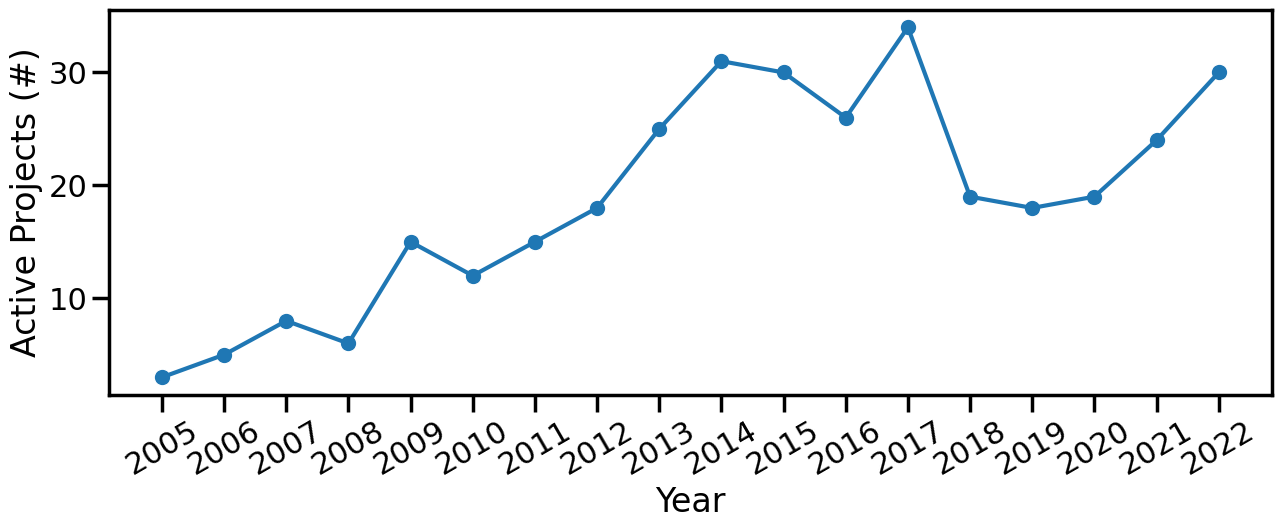

In [262]:
totcnt=totcnt[totcnt.Y<2023]

fig, ax=plt.subplots(1, figsize=(15,5))
sns.scatterplot(totcnt, x='Y',y='HP_ID', ax=ax)
sns.lineplot(totcnt, x='Y', y='HP_ID', ax=ax)
ax.set_xticks(totcnt.Y.unique(), totcnt.Y.unique(), rotation=30, horizontalalignment='center')
ax.set_xlabel('Year')
ax.set_ylabel('Active Projects (#)');

In [263]:
totcnt.columns

Index(['Y', 'HP_ID_HTS', 'HA_ID', 'HAP_ID', 'HP_ID_HTL', 'HLA_ID',
       'HLRS_ICL_ID', 'HP_ID', 'HSA_ID'],
      dtype='object')

In [264]:
assaycnt=totcnt[['Y', 'HSA_ID', 'HLA_ID','HA_ID',]]
assaycnt.columns=['Year','Active HTS Assays','Active HTL Assays','Total Assays']
assaycnt=assaycnt.melt(id_vars='Year', value_vars=['Active HTS Assays','Active HTL Assays','Total Assays'])
assaycnt.columns=['Year','Assay Type','Assay Count']

Text(0.5, 1.0, 'Active Assays over time')

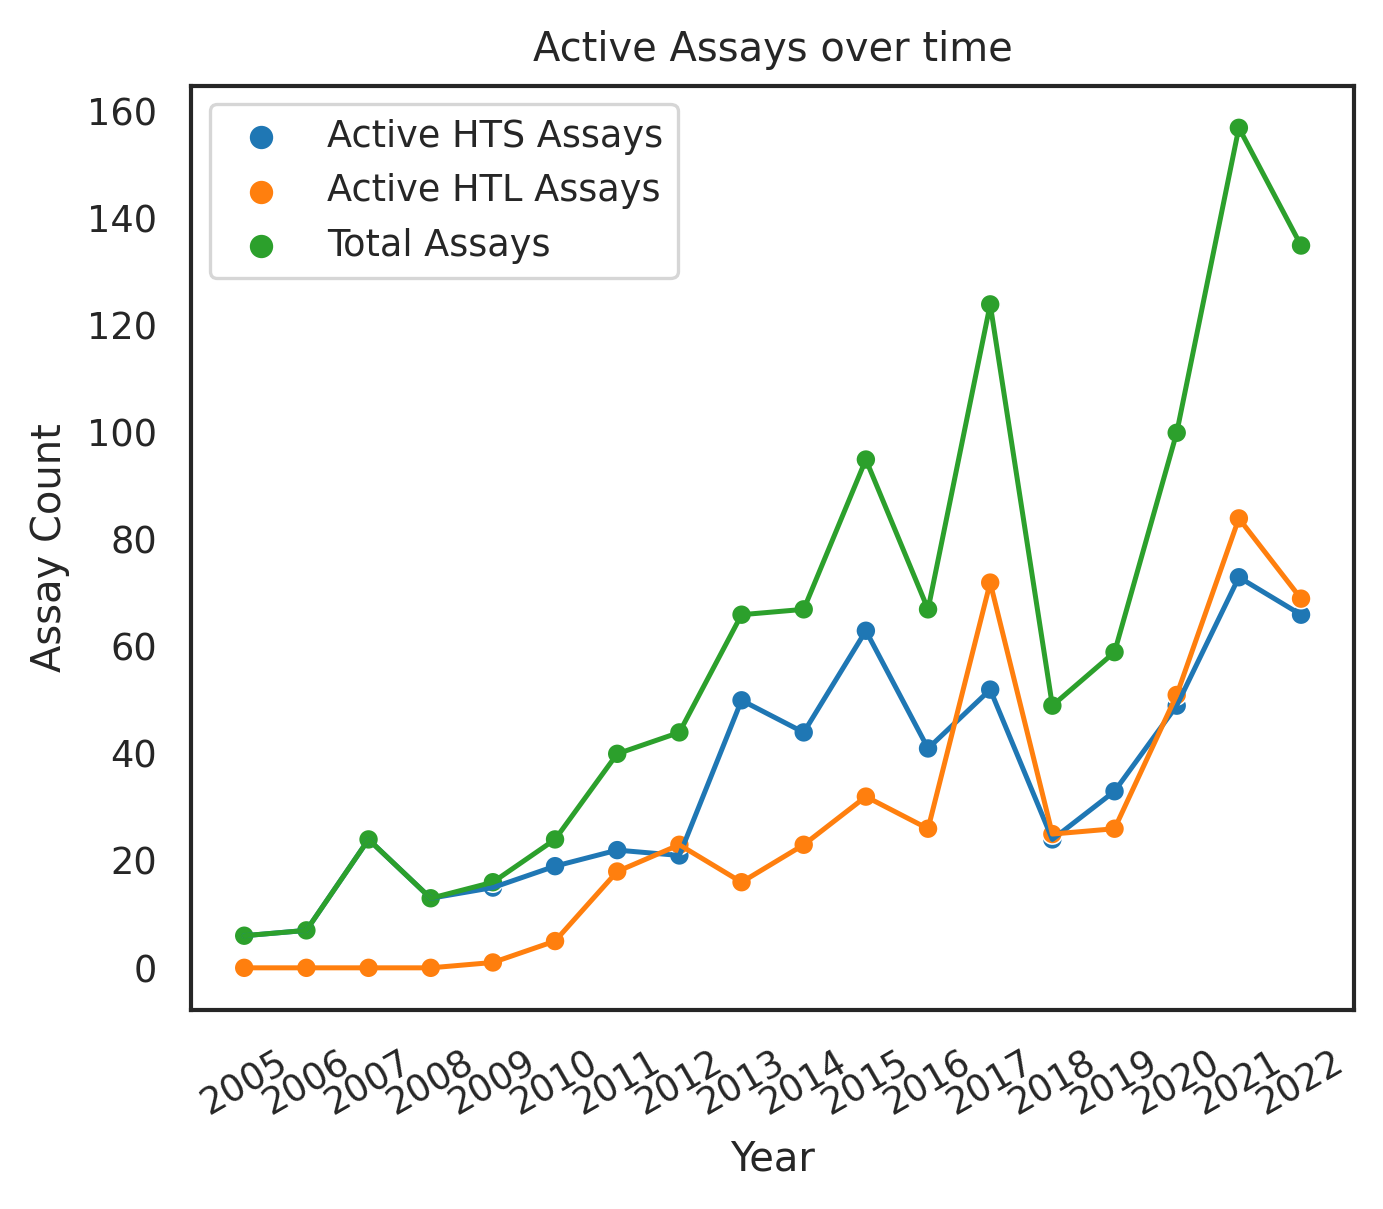

In [287]:
sns.set_context('paper')
fig, ax=plt.subplots(1, figsize=(5,4), dpi=300)
sns.scatterplot(assaycnt, x='Year',y='Assay Count', hue='Assay Type', ax=ax)
sns.lineplot(assaycnt, x='Year',y='Assay Count', hue='Assay Type', ax=ax)
ax.set_xticks(assaycnt.Year.unique(), assaycnt.Year.unique(), rotation=30, horizontalalignment='center')
handles,labels=ax.get_legend_handles_labels()
ax.legend(handles=handles[0:3],labels=labels[0:3])
# ax.set_xlabel('Year')
# ax.set_ylabel('Active Projects (#)');
ax.set_title('Active Assays over time')

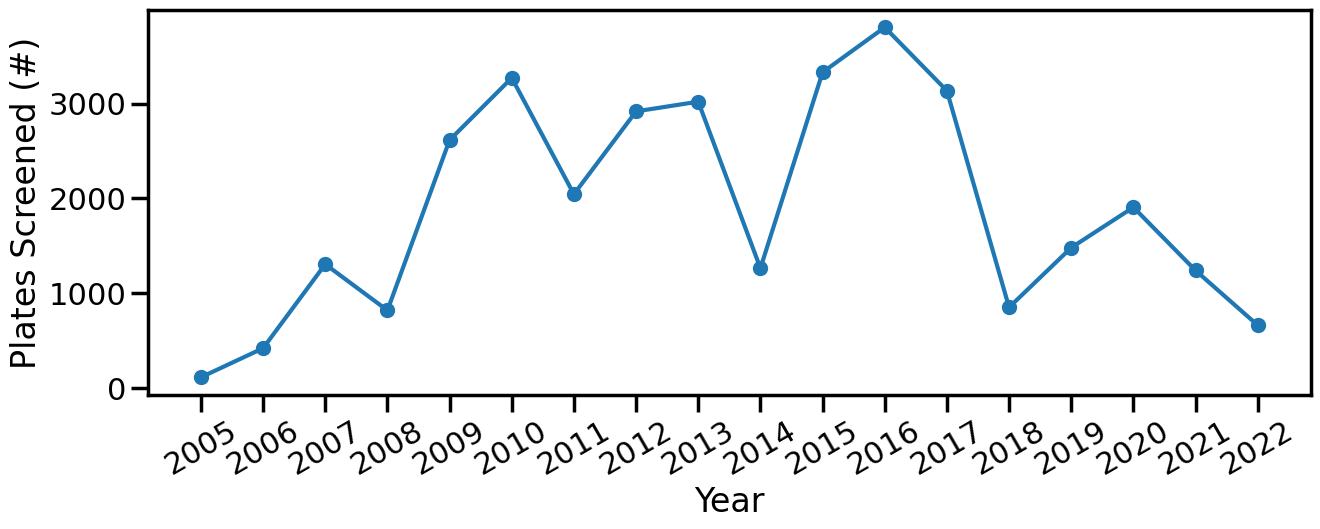

In [266]:
fig, ax=plt.subplots(1, figsize=(15,5))
sns.scatterplot(totcnt, x='Y',y='HAP_ID', ax=ax)
sns.lineplot(totcnt, x='Y', y='HAP_ID', ax=ax)
ax.set_xticks(totcnt.Y.unique(), totcnt.Y.unique(), rotation=30, horizontalalignment='center')
ax.set_xlabel('Year')
ax.set_ylabel('Plates Screened (#)');

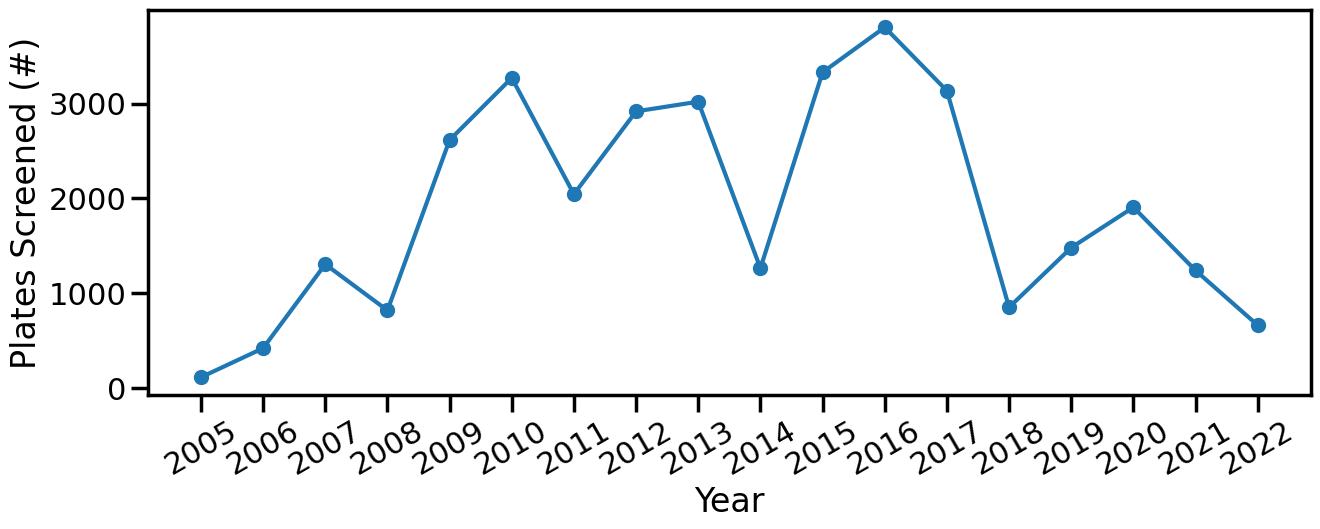

In [267]:
fig, ax=plt.subplots(1, figsize=(15,5))
sns.scatterplot(totcnt, x='Y',y='HAP_ID', ax=ax)
sns.lineplot(totcnt, x='Y', y='HAP_ID', ax=ax)
ax.set_xticks(totcnt.Y.unique(), totcnt.Y.unique(), rotation=30, horizontalalignment='center')
ax.set_xlabel('Year')
ax.set_ylabel('Plates Screened (#)');

# webapp users

In [403]:
wau_query="""
SELECT DISTINCT 
    id, 
    DATE(date_created) AS YEAR_CREATED,
    DATE(last_updated) AS YEAR_UPDATED,
    DATE(last_login_date) AS YEAR_LOGIN    
from WEBAPP_USER
"""
wau=pd.read_sql(wau_query,cnx)
# wau=wau[wau.YEAR_CREATED<2023]
wau['YEAR_CREATED']=pd.to_datetime(wau['YEAR_CREATED'])
wau['YEAR_UPDATED']=pd.to_datetime(wau['YEAR_UPDATED'])
wau['YEAR_LOGIN']=pd.to_datetime(wau['YEAR_LOGIN'])
# wau=wau.fillna(0)
wau['last_activity']=wau[['YEAR_UPDATED','YEAR_LOGIN']].max(axis=1)
wau['activity_length']=wau.last_activity-wau.YEAR_CREATED
wau=wau[wau.YEAR_UPDATED!='2017-11-28']
wau=wau[wau.activity_length>'0 days']
wau=wau.sort_values('YEAR_CREATED',ascending=False)
wau=wau.reset_index(drop=True)
wau.head(2)

,id,YEAR_CREATED,YEAR_UPDATED,YEAR_LOGIN,last_activity,activity_length
0,512,2023-01-12,2023-01-31,2023-01-31,2023-01-31,19 days
1,511,2022-11-16,2023-01-25,2022-11-16,2023-01-25,70 days


In [404]:
print(wau.shape)
wau.shape

(227, 6)


(227, 6)

Text(0.5, 1.0, 'Long term web app user activity over time')

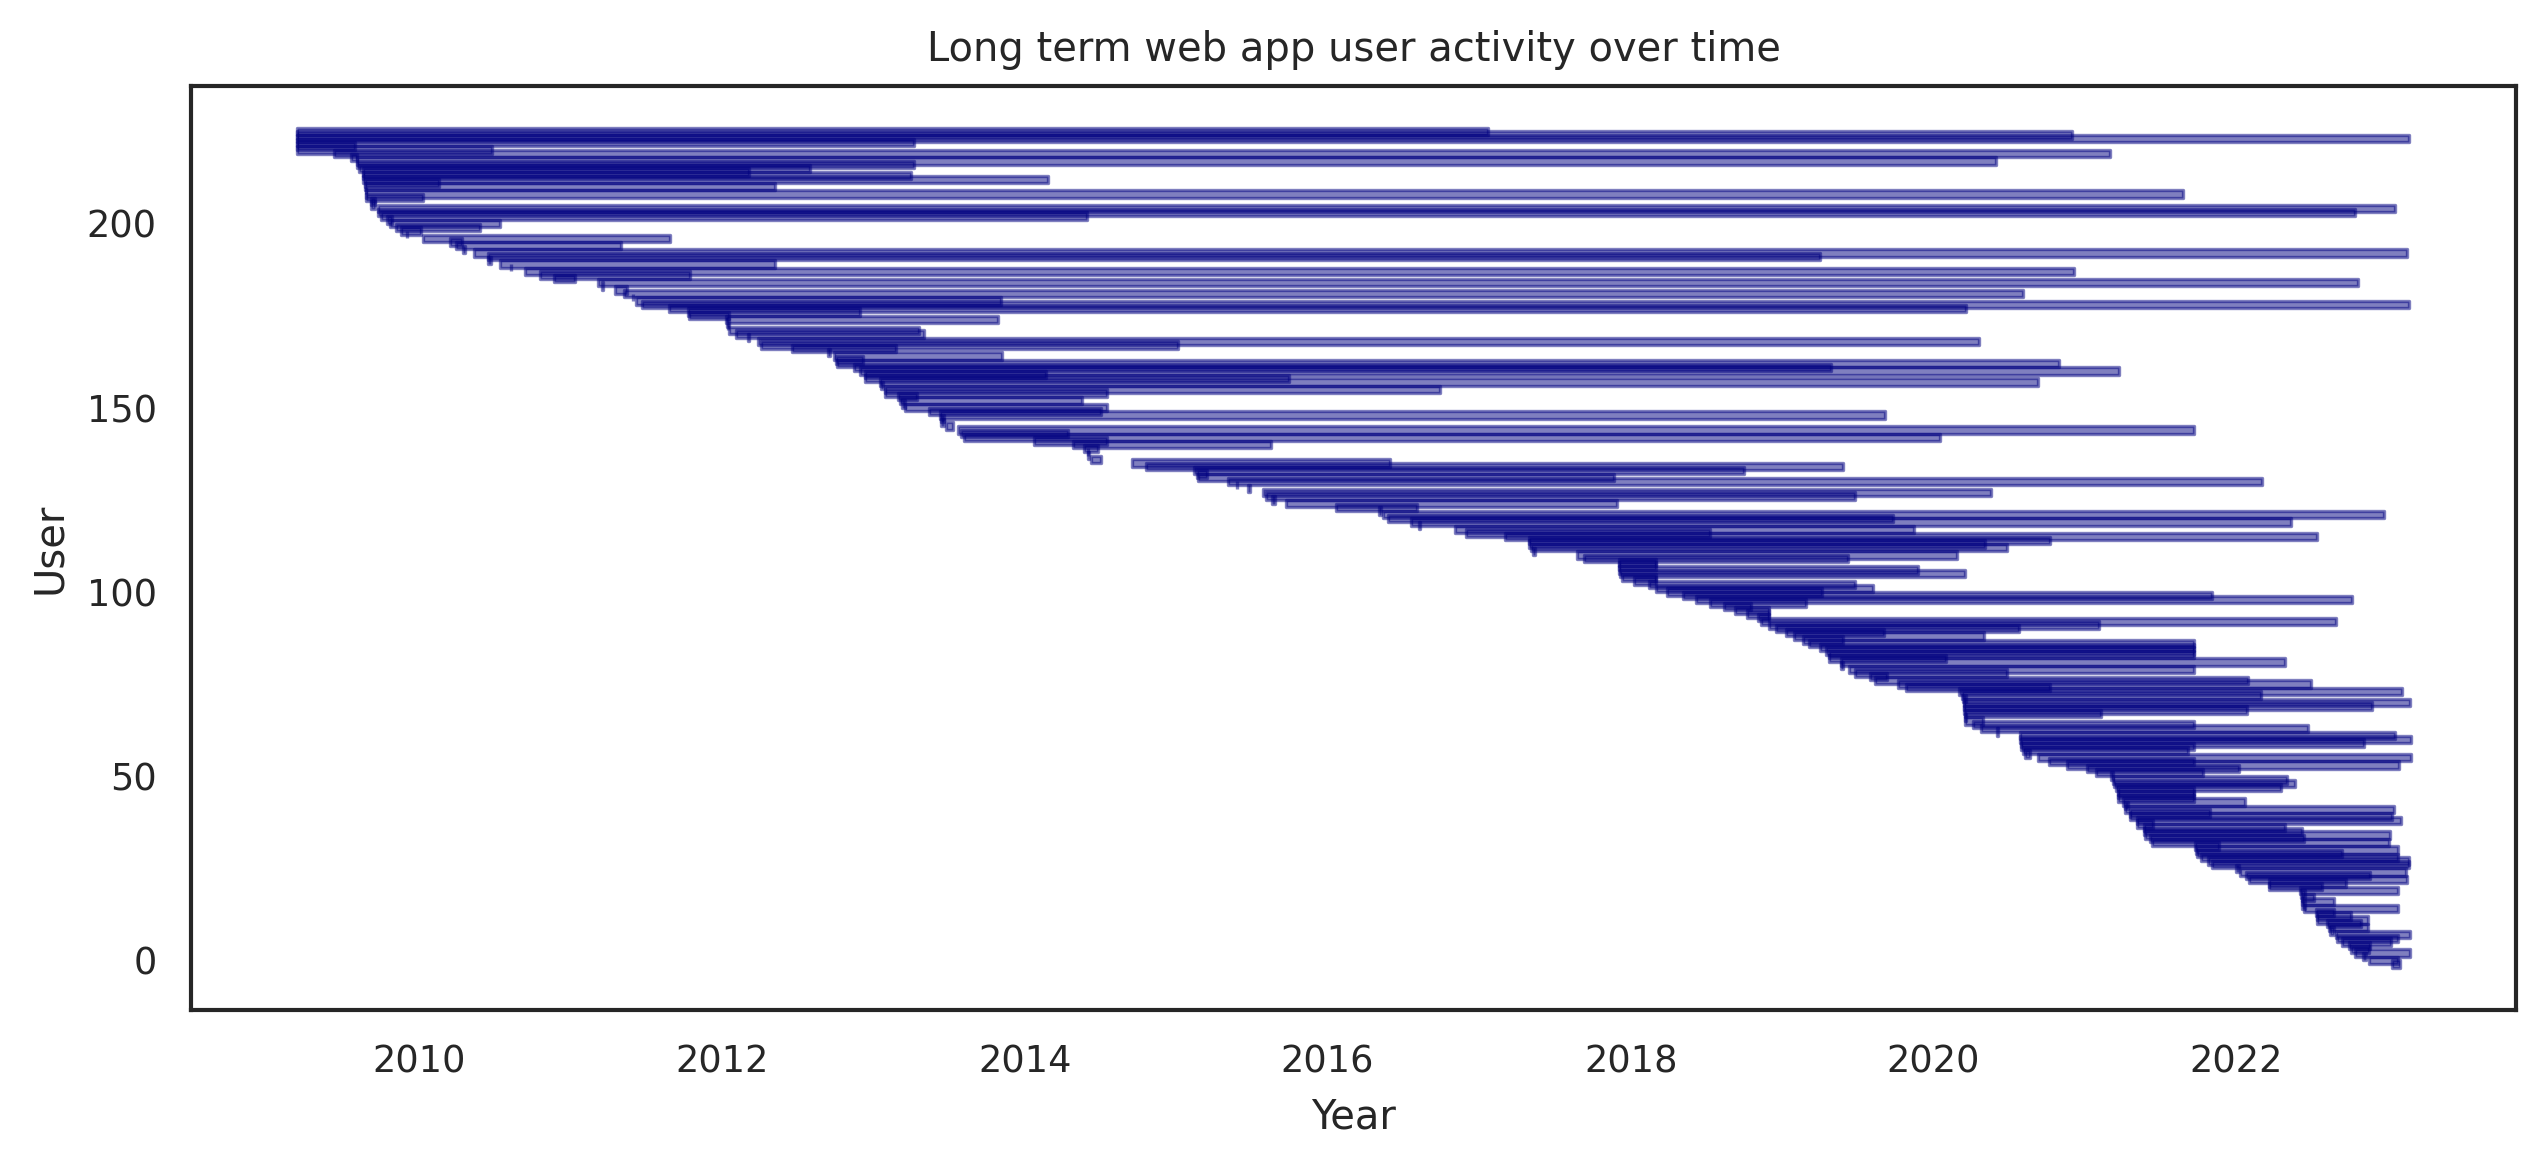

In [406]:
sns.set_context('paper')
fig, ax=plt.subplots(1, figsize=(10,4), dpi=300)
for index, row in wau.sort_values(by='YEAR_CREATED', ascending=False).iterrows():
    start_year = row.YEAR_CREATED
    duration = row.activity_length
    ax.broken_barh([(start_year, duration)],
                    (index,-2), alpha=0.5,color='navy')
    # ax.text(start_year+0.5, index-0.2, row.index)
    # ax.invert_yaxis()
ax.set_xlabel('Year')
ax.set_ylabel('User')
ax.set_title('Long term web app user activity over time')

In [419]:
wau=wau.sort_values('id', ascending=False)
wau=wau.reset_index(drop=True)
wau['id']=wau.index
wau

,id,YEAR_CREATED,YEAR_UPDATED,YEAR_LOGIN,last_activity,activity_length
0,0,2009-03-13,2017-01-23,NaT,2017-01-23,2873 days
1,1,2009-03-13,2020-11-30,2020-11-30,2020-11-30,4280 days
2,2,2009-03-13,2023-02-22,2023-02-22,2023-02-22,5094 days
3,3,2009-03-13,2013-04-08,NaT,2013-04-08,1487 days
4,4,2009-03-13,2009-07-31,NaT,2009-07-31,140 days
...,...,...,...,...,...,...
222,222,2022-10-03,2022-11-16,2022-11-16,2022-11-16,44 days
223,223,2022-10-14,2023-02-24,2023-02-24,2023-02-24,133 days
224,224,2022-11-01,2022-11-09,NaT,2022-11-09,8 days
225,225,2022-11-16,2023-01-25,2022-11-16,2023-01-25,70 days


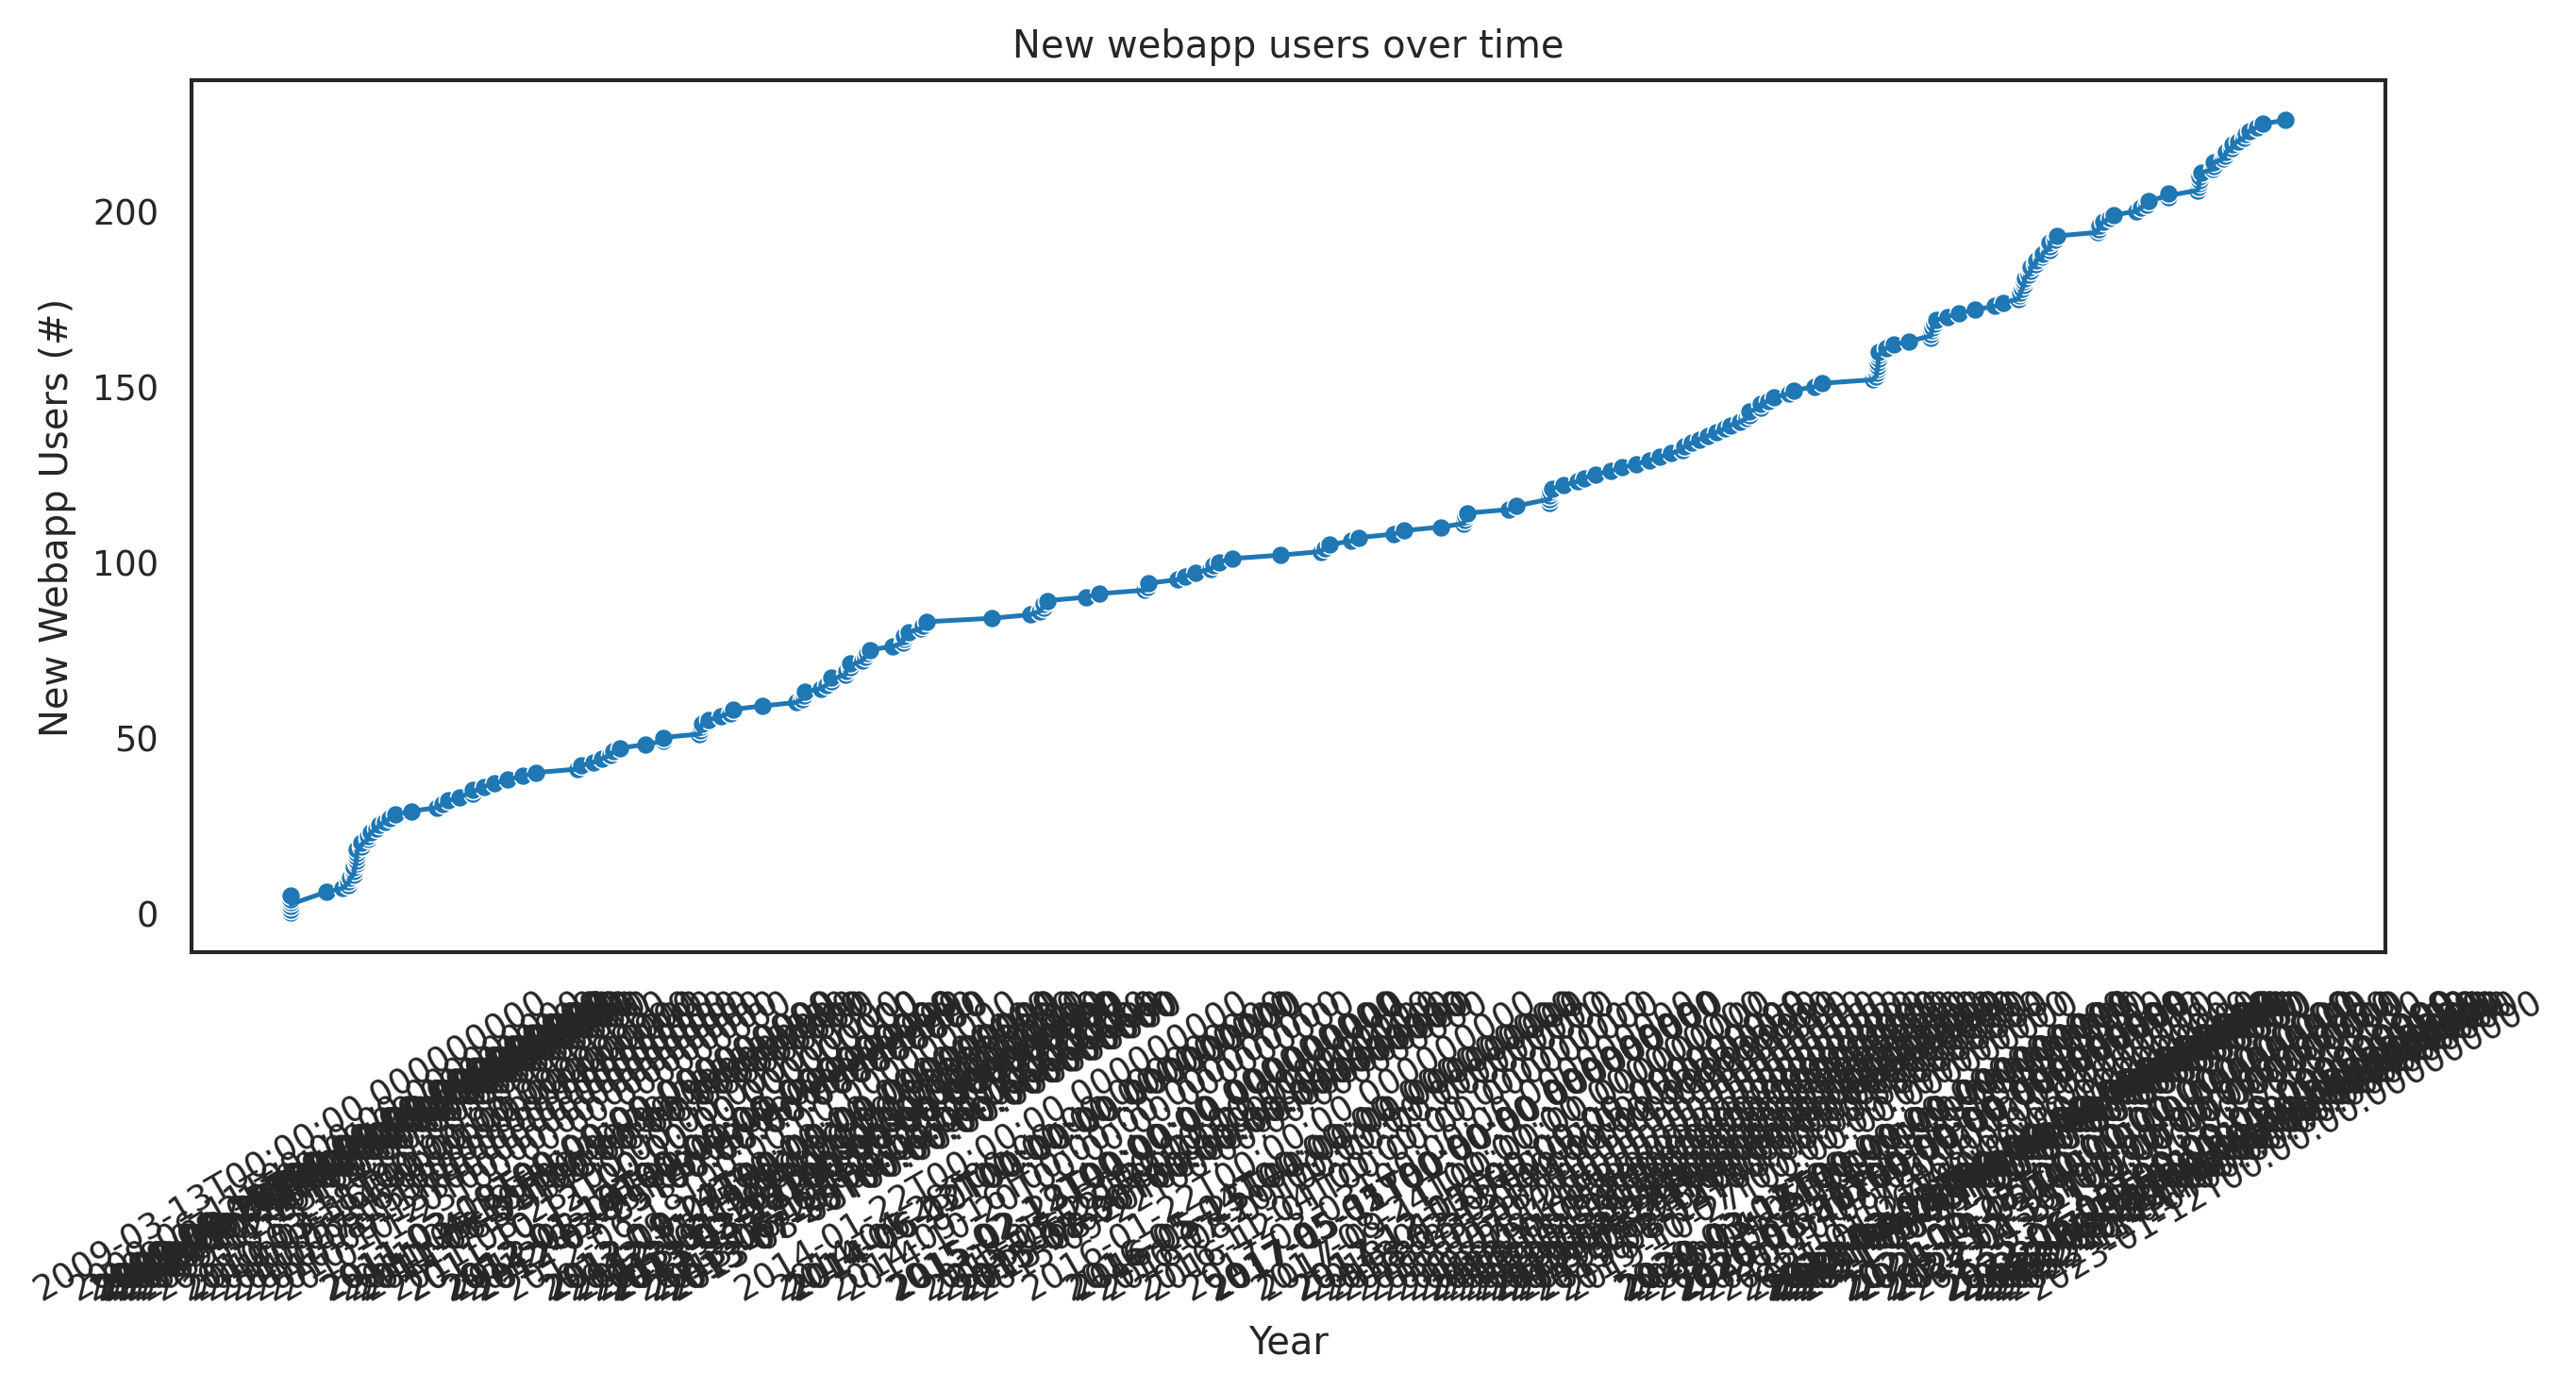

In [420]:
import matplotlib.dates as mdates

fig, ax=plt.subplots(1, figsize=(10,4), dpi=300)
sns.scatterplot(wau, x='YEAR_CREATED',y='id', ax=ax)
sns.lineplot(wau, x='YEAR_CREATED',y='id', ax=ax)

ax.set_xticks(wau.YEAR_CREATED.unique(), wau.YEAR_CREATED.unique(), rotation=30, horizontalalignment='center')
ax.set_xlabel('Year')
ax.set_ylabel('New Webapp Users (#)');
ax.set_title('New webapp users over time');

In [461]:
cnx.dispose()